# Make_More V3
#### Make Make_More even more powerfull
-we encounter the lowest dev loss of 2.17
- TO IMPROVE THE PERFORMENCE

- We can observe the intial loss of our model is very high, which we need to look into



In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures

# from Transformers.NanoGPT import vocab_size
%matplotlib inline


In [7]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
len(words)

32033

In [9]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [10]:
block_size = 3
context = [0] * block_size


def build_datasets(words):
    X , Y = [] , []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("X:" , X ,  "Y:" , Y)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_datasets(words[:n1])  # 80% of Xtr
Xdev, Ydev = build_datasets(words[n1:n2]) # 10%
Xte, Yte = build_datasets(words[n2:]) # 10%

print(f'Xtr: {Xtr.shape}, Ytr: {Ytr.shape}')
print(f'Xdev: {Xdev.shape}, Ydev: {Ydev.shape}')
print(f'Xte: {Xte.shape}, Yte: {Yte.shape}')



Xtr: torch.Size([182594, 3]), Ytr: torch.Size([182594])
Xdev: torch.Size([22846, 3]), Ydev: torch.Size([22846])
Xte: torch.Size([22706, 3]), Yte: torch.Size([22706])


In [11]:
print(Xtr.size(), Ytr.size(), Xte.size(), Yte.size())

torch.Size([182594, 3]) torch.Size([182594]) torch.Size([22706, 3]) torch.Size([22706])


<img src="Transformers/images/img.png">

In [12]:
# ------------- > lets make this more cleaner

<div >
<p>In order to decreace the intial loss we need to make our intial forward pass logits close to zero. </br>
To make it possible, (reduce the loss): lets try to reduce W2 to some fator of 0.01
 </br>
 and b1 to zeros </p>
</div>

In [75]:
n_embd = 10  # dimensionality of the character level embedding vectors
n_hidden = 200  # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2323938434709) # for reproducibility
# look up table --> 2-10 (increasing embedding dim)
C = torch.rand(vocab_size, n_embd,                      generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden),         generator=g)*0.001
b1 = torch.randn(n_hidden,                              generator=g)*0.01
W2 = torch.randn((n_hidden, vocab_size),                generator=g)* 0.01
b2 = torch.randn(vocab_size,                            generator=g)* 0

parameters = [C, W1, b1, W2, b2]
print(f"Total_parameters :{sum(p.nelement() for p in parameters)}") # total num of parameters

for p in parameters:
    p.requires_grad = True

Total_parameters :11897


In [76]:
epochs = 200000
batch_size = 32
lossi = []

for epoch in range(epochs):

    # mini_batch Constructor
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X and Y

    # Forward pass
    emb = C[Xb]  # (32, 3, 10)
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors

    # non- linearity
    hpreat = embcat @ W1 + b1 # hiden layer pre activations
    h = torch.tanh(hpreat)  # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    # lr = lrs[i]
    lr = 0.1 if epoch < 100000 else 0.01
    for p in parameters:
        learning_rate = -lr
        p.data += learning_rate * p.grad

    # tracking status
    # lri.append(lre[i])
    if epoch % 10000 ==0:
        print(f'epoch :{epoch:7d}/{epochs:7d}: loss {loss.item():.4f}')
    #
    lossi.append(loss.log10().item())



epoch :      0/ 200000: loss 3.2950
epoch :  10000/ 200000: loss 2.0099
epoch :  20000/ 200000: loss 2.0641
epoch :  30000/ 200000: loss 1.9198
epoch :  40000/ 200000: loss 2.4056
epoch :  50000/ 200000: loss 2.5143
epoch :  60000/ 200000: loss 2.1681
epoch :  70000/ 200000: loss 2.3666
epoch :  80000/ 200000: loss 2.3417
epoch :  90000/ 200000: loss 1.9738
epoch : 100000/ 200000: loss 2.1842
epoch : 110000/ 200000: loss 1.6401
epoch : 120000/ 200000: loss 2.2061
epoch : 130000/ 200000: loss 2.1339
epoch : 140000/ 200000: loss 2.0106
epoch : 150000/ 200000: loss 1.8740
epoch : 160000/ 200000: loss 2.2142
epoch : 170000/ 200000: loss 2.2711
epoch : 180000/ 200000: loss 2.2451
epoch : 190000/ 200000: loss 2.1369


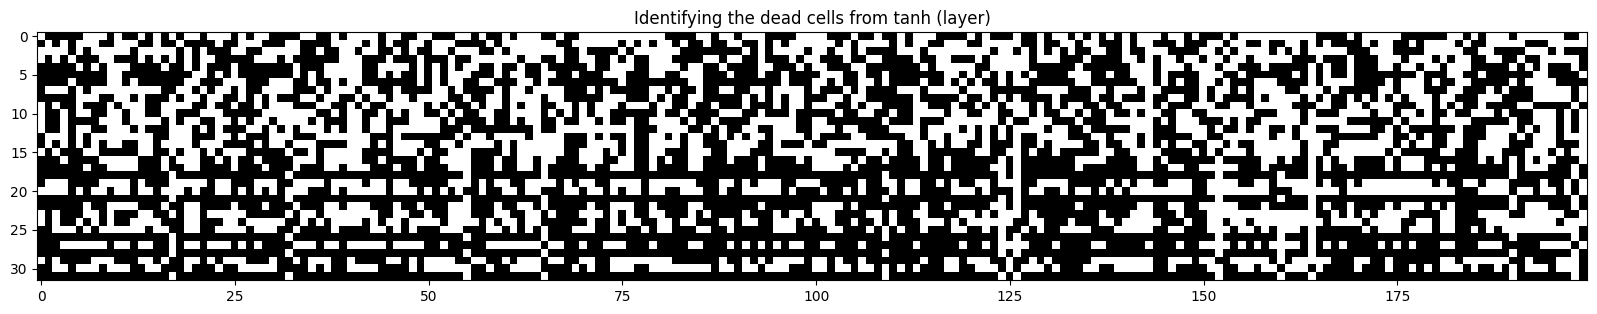

In [56]:
plt.figure(figsize=(20,10))
plt.title('Identifying the dead cells from tanh (layer)')
plt.imshow(h.abs() > 0.99, cmap="grey", interpolation="nearest");

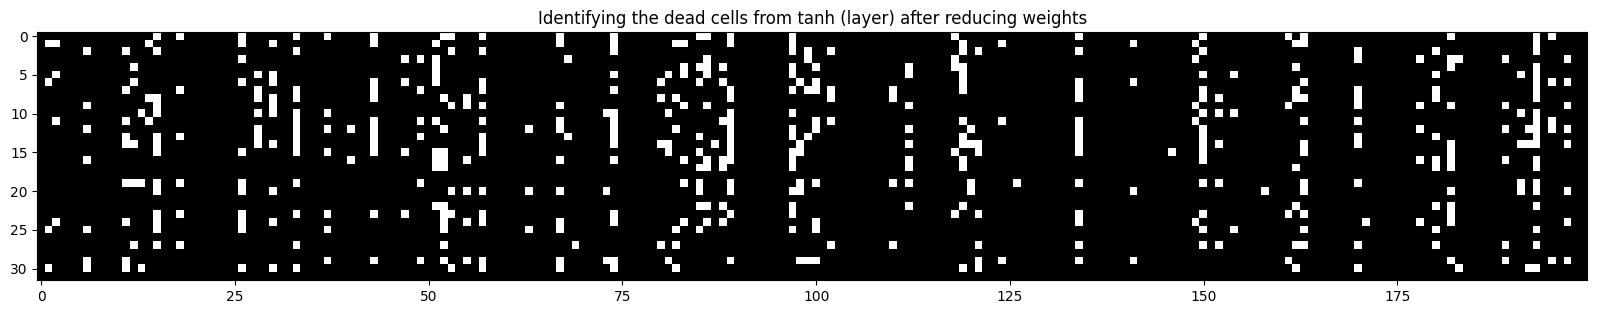

In [77]:
plt.figure(figsize=(20,10))
plt.title('Identifying the dead cells from tanh (layer) after reducing weights')
plt.imshow(h.abs() > 0.99, cmap="grey", interpolation="nearest");

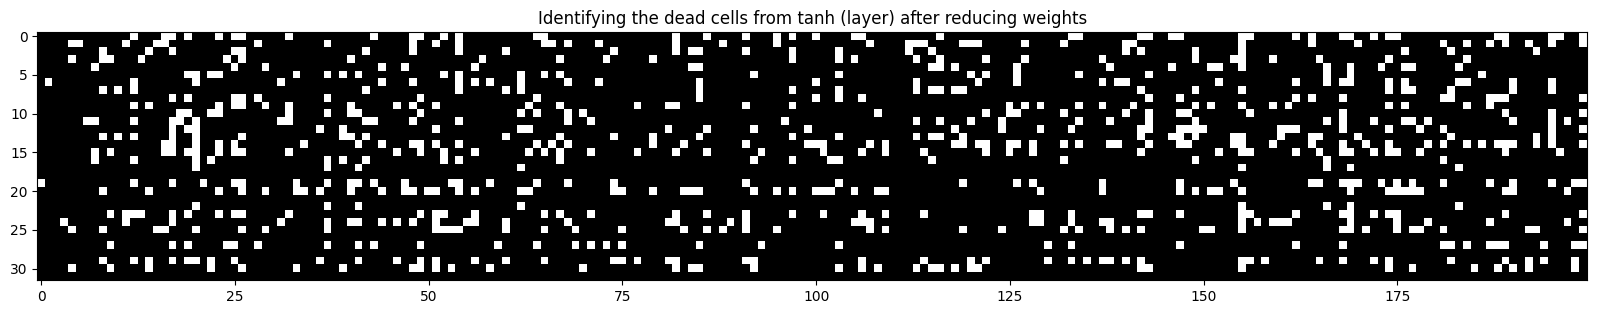

In [66]:
plt.figure(figsize=(20,10))
plt.title('Identifying the dead cells from tanh (layer) after reducing weights')
plt.imshow(h.abs() > 0.99, cmap="grey", interpolation="nearest");

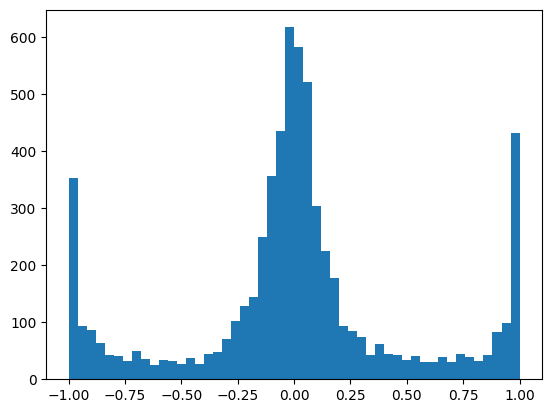

In [78]:
plt.hist(h.view(-1).tolist(), bins=50);

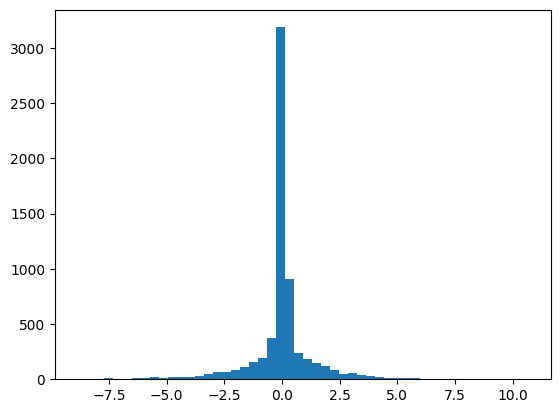

In [73]:
plt.hist(hpreat.view(-1).tolist(),  bins=50);

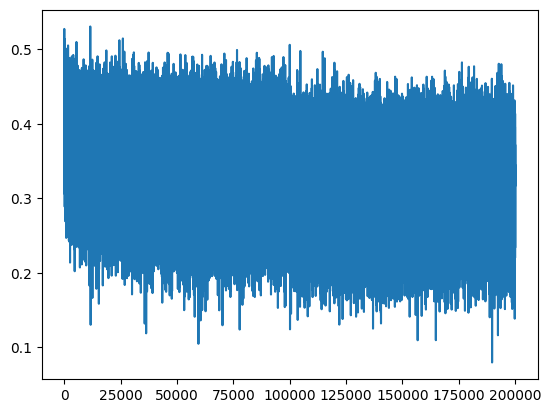

In [23]:
plt.plot(lossi)

## Overall Training loss

In [25]:
@torch.no_grad() # decorator helps to disable gradient traking during backward pass
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'valid' : (Xdev,Ydev),
        'test' : (Xte,Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreat = embcat @ W1 + b1
    h = torch.tanh(hpreat)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss :{loss.item()}')

split_loss("train")
split_loss("valid")

train loss :2.0749599933624268
valid loss :2.131558418273926


In [ ]:
#
# train loss :2.0749599933624268
# valid loss :2.131558418273926



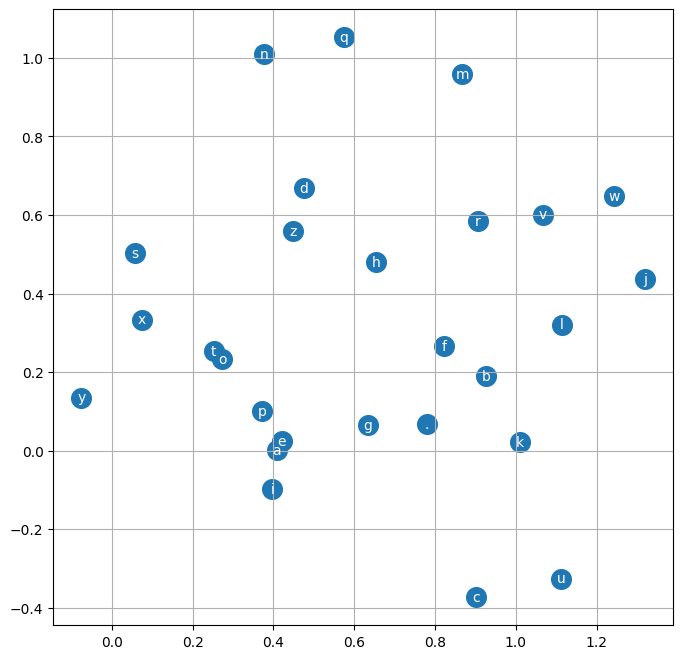

In [73]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [120]:
# sample from the model
g = torch.Generator().manual_seed(2147483657)

for _ in range(20):
    out = []
    # intializing with all zeros [0,0,0] (...)
    context = [0] * block_size
    while True:
        # forward pass to the nerual network
        embed = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(embed.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sampling from the distribution using multinomial
        ix = torch.multinomial(probs, num_samples=1, generator=g)

        # shifting the context window ... ---> e ==> ..e --> m
        context = context[1:] + [ix]
        out.append(ix.item())
        # if the sample is special token (.) break
        if ix ==0:
            break
    # decoding the output embeddings
    print(''.join(itos[i] for i in out))





carmahzati.
havi.
kimrix.
taty.
hacaylie.
mahita.
deliah.
jarqui.
nellara.
chaiivon.
leigh.
ham.
pori.
quintis.
lilei.
jadiquoanthoniearynix.
kaelishuat.
emme.
iia.
gian.
